In [2]:
import autograd.numpy as np
from autograd import grad, hessian
from autograd import elementwise_grad
from scipy.optimize import fmin_l_bfgs_b, fmin_bfgs, fmin_cg, fmin_ncg
import matplotlib.pyplot as plt
from scipy.linalg import cho_factor, cho_solve, cholesky
from autograd.scipy.linalg import solve_triangular
from sklearn.decomposition import FactorAnalysis, PCA
from sklearn.linear_model import LogisticRegression
from autograd.misc.optimizers import adam
import copy
import glob
import imageio
import skimage
from skimage import data, io, filters
from sklearn.model_selection import train_test_split
import pickle
import pandas as pd
import seaborn as sns

In [3]:
def get_labels(filenames):
    labels = np.zeros(len(filenames))
    for i in range(len(filenames)):
        if any(s in filenames[i] for s in ('sad', 'wink', 'surprised', 'sleepy', 'happy')):
            labels[i] = 1
    return labels


img_arr_train = np.array([skimage.img_as_float(skimage.transform.rescale(imageio.imread(file),1.0 / 4.0)) for file in glob.glob('yale_train/*png')])
img_arr_test = np.array([skimage.img_as_float(skimage.transform.rescale(imageio.imread(file),1.0 / 4.0)) for file in glob.glob('yale_test/*png')])
X_train = np.reshape(img_arr_train, (img_arr_train.shape[0], img_arr_train.shape[1]*img_arr_train.shape[2]))
X_test = np.reshape(img_arr_test, (img_arr_test.shape[0], img_arr_test.shape[1]*img_arr_test.shape[2]))
y_train = get_labels(glob.glob('yale_train/*png'))
y_test = get_labels(glob.glob('yale_test/*png'))

/anaconda2/lib/python2.7/site-packages/skimage/transform/_warps.py:24: UserWarning: The default multichannel argument (None) is deprecated.  Please specify either True or False explicitly.  multichannel will default to False starting with release 0.16.
  warn('The default multichannel argument (None) is deprecated.  Please '
/anaconda2/lib/python2.7/site-packages/skimage/transform/_warps.py:105: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "
/anaconda2/lib/python2.7/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/anaconda2/lib/python2.7/site-packages/skimage/transform/_warps.py:24: UserWarning: The default multichannel argument (None) is deprecated.  Please specify either True or Fa

/anaconda2/lib/python2.7/site-packages/skimage/transform/_warps.py:24: UserWarning: The default multichannel argument (None) is deprecated.  Please specify either True or False explicitly.  multichannel will default to False starting with release 0.16.
  warn('The default multichannel argument (None) is deprecated.  Please '
/anaconda2/lib/python2.7/site-packages/skimage/transform/_warps.py:105: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "
/anaconda2/lib/python2.7/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/anaconda2/lib/python2.7/site-packages/skimage/transform/_warps.py:24: UserWarning: The default multichannel argument (None) is deprecated.  Please specify either True or Fa

/anaconda2/lib/python2.7/site-packages/skimage/transform/_warps.py:24: UserWarning: The default multichannel argument (None) is deprecated.  Please specify either True or False explicitly.  multichannel will default to False starting with release 0.16.
  warn('The default multichannel argument (None) is deprecated.  Please '
/anaconda2/lib/python2.7/site-packages/skimage/transform/_warps.py:105: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "
/anaconda2/lib/python2.7/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/anaconda2/lib/python2.7/site-packages/skimage/transform/_warps.py:24: UserWarning: The default multichannel argument (None) is deprecated.  Please specify either True or Fa

In [4]:

def transform(f, bias, cov_noise, x):
    cov_x = np.einsum("dl,ml->dm",f,f) + cov_noise
    temp = np.linalg.solve(cov_x, (x - bias).T)
    mean_z = np.einsum("dl,dn->nl", f, temp)
    return mean_z
def decode_parameters(params, D, latent_dim, opt):
    size_f = D*latent_dim
    f =  params[:size_f]
    #f = f*np.array([0,1]) + np.array([1,0])
    f =  f.reshape(D, latent_dim)
    bias_x = params[size_f:size_f+D]
    if (opt=="ppca"):
        var = params[size_f+D]
        cov_noise= np.diag(np.ones(D)*np.log(1+np.exp(var)))
        #cov_noise= np.diag(np.ones(D)*np.exp(var))
        w = params[size_f+D+1:]
    else:
        var = params[size_f+D:size_f+D*2]
        cov_noise= np.diag(np.log(1+np.exp(var)))
        w = params[size_f+D*2:]
    return f, bias_x, cov_noise, w

In [392]:
latent_dim = 2
with open('params_hinge_all_latent_2_take_2.pkl') as f:  
    [best_params_opt_l_bfgs_b, final_obj_val_l_bfgs_b, test_acc_l_bfgs_b, train_acc_l_bfgs_b, pll_l_bfgs_b_train, pll_l_bfgs_b_test, ll_l_bfgs_b_train, ll_l_bfgs_b_test, reg_weights, pred_weights] = pickle.load(f)   

In [367]:
import re
def get_subjects(filenames):
    subjects = np.zeros(len(filenames))
    for i in range(len(filenames)):
        subjects[i] = int(re.search(r"\d\d", filenames[i]).group(0))
    return subjects

def attribute_category(name):
    if 'sad' in name:
        c = '1' 
    elif    'wink' in name:
        c = '2'
    elif    'surprised' in name:
        c = '3'
    elif    'sleepy' in name: 
        c = '4'
    elif    'happy' in name: 
        c = '5'
    elif    'noglasses' in name:
        c = '-1'
    elif    'normal' in name:
        c = '-2'
    elif    'leftlight' in name:
        c = '-3'
    elif    'rightlight' in name:
        c = '-4'
    else:
        c = '-5'

    return c
def decode_category(category):
    if category == 1:
        c = 'sad' 
    elif category == 2:
        c = 'wink' 
    elif category == 3:
        c = 'surprised'
    elif category == 4:
        c = 'sleepy'
    elif category == 5:
        c = 'happy'
    elif category == -1:
        c = 'noglasses'
    elif category == -2:
        c = 'normal'
    elif category == -3:
        c = 'leftlight'
    elif category == -4:
        c = 'rightlight'
    else:
        c = 'centerlight'
    #print category, c
    return c

def get_categories(filenames):
    categories = []
    for i in range(len(filenames)):
        categories.append(attribute_category(filenames[i]))
    return categories

In [364]:
def plot_2D(df_test, filename, title, clf_pc, misclassified_idxs, isequal):
    plt.figure(figsize=(10,10))

    for i in misclassified_idxs:
         plt.text(df_test.dim1[i]+0.0002, df_test.dim2[i], i, horizontalalignment='left', size='large', color='black')
    plt.title(title, fontsize=14)
    w = clf_pc.coef_[0]
    a = -w[0] / w[1]
    xx = np.linspace(np.min(df_test.dim1), np.max(df_test.dim1))
    yy = a * xx - (clf_pc.intercept_) / w[1]

    plt.plot(xx, yy, 'k-')
    sns.scatterplot(x="dim1", y="dim2", hue="category", style="subject", data=df_test,s =200, palette = sns.diverging_palette(1, 250, sep=1, n=10))
    L=plt.legend()
    for i in range(1, 11):
        text_category = decode_category(int(L.get_texts()[i]._text))
        L.get_texts()[i].set_text(text_category)
    L.get_texts()[0].set_text('CATEGORY')
    L.get_texts()[11].set_text('TEST SUBJECT')
    
    plt.xlabel("Dim 1")
    plt.ylabel("Dim 2")
    min_bound = min(np.min(df_test.dim1), np.min(df_test.dim2))
    max_bound = max(np.max(df_test.dim1), np.max(df_test.dim2))
    
    plt.xlim(min_bound - 0.002*min_bound, max_bound+ 0.002*max_bound)
    plt.axis('equal')

    #plt.ylim(min_bound - 0.002*min_bound, max_bound+ 0.002*max_bound)
    plt.savefig(filename)
    


In [394]:
regular_weight_id, pred_weight_id = np.unravel_index(np.argmax(test_acc_l_bfgs_b), (test_acc_l_bfgs_b.shape))
#regular_weight_id = 1
#pred_weight_id = 3
print test_acc_l_bfgs_b[regular_weight_id, pred_weight_id]
print reg_weights[regular_weight_id]
print pred_weights[pred_weight_id]


0.7
1000.0
10000.0


In [395]:
filenames_test = glob.glob('yale_test/*png')
categories_test = get_categories(filenames_test)
subjects_test = get_subjects(filenames_test)
latent_dim = 2
x_dim = X_train.shape[1]      
opt = "ppca"  
f_best, bias_best, cov_noise_best, w_best = decode_parameters(best_params_opt_l_bfgs_b[regular_weight_id, pred_weight_id], x_dim, latent_dim, opt)
print f_best.shape
q_best, r_best = np.linalg.qr(f_best)
print q_best.shape

(3100, 2)
(3100, 2)


In [396]:
X_test_proj_best_q = transform(q_best, bias_best, cov_noise_best, X_test)
X_train_proj_best_q = transform(q_best, bias_best, cov_noise_best, X_train)
X_test_proj_best_f = transform(f_best, bias_best, cov_noise_best, X_test)
X_train_proj_best_f = transform(f_best, bias_best, cov_noise_best, X_train)

In [397]:
scores_q = np.ones(len(pows))
scores_f_learned =  np.ones(len(pows))
clf_pc_q = []
for i in range (len(pows)):
    c = 10**(pows[i])
    clf = LogisticRegression(C = c).fit(X_train_proj_best_q, y_train)
    clf_pc_q.append(clf)
    scores_q[i]  = clf.score(X_test_proj_best_q, y_test)
    clf_pc_f_learned = LogisticRegression(C = c).fit(X_train_proj_best_f, y_train)
    scores_f_learned[i]= clf_pc_f_learned.score(X_test_proj_best_f, y_test)

c_best_q = 10**pows[np.argmax(scores_q)]
reg_weight_q = 1./c_best_q
clf_pc_q_best= clf_pc_q[np.argmax(scores_q)]

print c_best_q
print reg_weight_q
print np.max(scores_q)
print scores_q
print scores_f_learned

0.1
10.0
0.725
[0.625 0.625 0.625 0.625 0.625 0.625 0.625 0.6   0.675 0.725 0.7   0.7
 0.7   0.7   0.7   0.7   0.7   0.7   0.7   0.7   0.7   0.7   0.7   0.7
 0.7   0.7   0.7   0.7   0.7   0.7  ]
[0.7   0.7   0.7   0.7   0.7   0.7   0.7   0.7   0.7   0.7   0.675 0.7
 0.7   0.7   0.7   0.7   0.7   0.7   0.7   0.7   0.7   0.7   0.7   0.7
 0.7   0.7   0.7   0.7   0.7   0.7  ]


In [372]:
scores_raw = np.ones(30)
for i in range (len(pows)):
    c = 10**(pows[i])
    clf = LogisticRegression(C = c).fit(X_train, y_train)
    scores_raw[i]  = clf.score(X_test, y_test)
c_best_raw = 10**pows[np.argmax(scores_raw)]
reg_weight_raw = 1./(c_best_raw)
print c_best_raw
print reg_weight_raw
print np.max(scores_raw)
print scores_raw

100000
1e-05
0.775
[0.5   0.5   0.5   0.5   0.5   0.5   0.5   0.625 0.675 0.675 0.7   0.675
 0.7   0.75  0.75  0.775 0.75  0.775 0.775 0.775 0.775 0.775 0.775 0.775
 0.775 0.775 0.775 0.775 0.775 0.775]


0.7


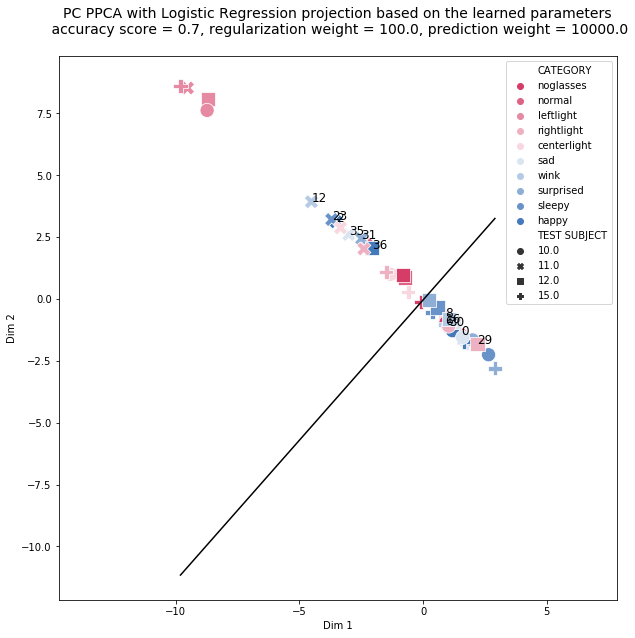

In [389]:
clf_pc_f = LogisticRegression()
clf_pc_f.coef_ = w_best[1:].reshape(1,  latent_dim)
clf_pc_f.intercept_ = w_best[0]
clf_pc_f.classes_ = np.array([0, 1])
print clf_pc_f.score(X_test_proj_best_f, y_test)

y_test_pred_f = clf_pc_f.predict(X_test_proj_best_f)
misclassified_idxs_f = np.argwhere(y_test_pred_f!=y_test)[:,0]
class0_idxs_f = np.argwhere(y_test_pred_f==0)[:,0]
class1_idxs_f = np.argwhere(y_test_pred_f==1)[:,0]

filename_f = "logit_projection_yale_acc{}_pred{}_reg{}_take2_f.png".format(test_acc_l_bfgs_b[regular_weight_id, pred_weight_id],pred_weights[pred_weight_id], reg_weights[regular_weight_id])
df_test_f = pd.DataFrame({
    'dim1': X_test_proj_best_f[:,0],
    'dim2': X_test_proj_best_f[:,1],
    'pred_labels': y_test_pred_f,
    'true_labels': y_test,
    'filename': filenames_test,
    'category': categories_test,
    'subject': subjects_test    
    })
title_f = "PC PPCA with Logistic Regression projection based on the learned parameters\n accuracy score = {}, regularization weight = {}, prediction weight = {}\n".format(test_acc_l_bfgs_b[regular_weight_id, pred_weight_id], reg_weights[regular_weight_id], pred_weights[pred_weight_id])
plot_2D(df_test_f, filename_f,title_f,  clf_pc_f, misclassified_idxs_f, True)

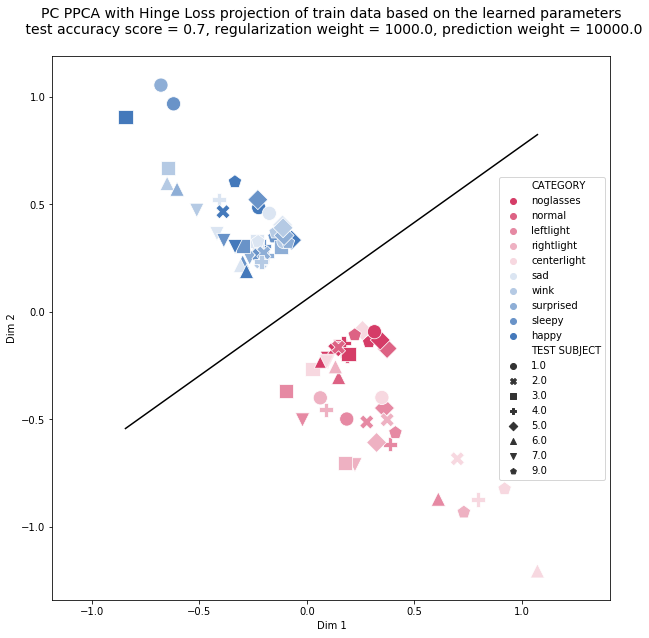

In [398]:
clf_pc_f = LogisticRegression()
clf_pc_f.coef_ = w_best[1:].reshape(1,  latent_dim)
clf_pc_f.intercept_ = w_best[0]
clf_pc_f.classes_ = np.array([0, 1])

y_train_pred_f = clf_pc_f.predict(X_train_proj_best_f)
misclassified_idxs_f = np.argwhere(y_train_pred_f!=y_train)[:,0]
class0_idxs_f = np.argwhere(y_train_pred_f==0)[:,0]
class1_idxs_f = np.argwhere(y_train_pred_f==1)[:,0]

filename_f = "hinge_projection_yale_acc{}_pred{}_reg{}_take2_f_train.png".format(test_acc_l_bfgs_b[regular_weight_id, pred_weight_id],pred_weights[pred_weight_id], reg_weights[regular_weight_id])
filenames_train = glob.glob('yale_train/*png')
categories_train = get_categories(filenames_train)
subjects_train = get_subjects(filenames_train)

df_train_f = pd.DataFrame({
    'dim1': X_train_proj_best_f[:,0],
    'dim2': X_train_proj_best_f[:,1],
    'pred_labels': y_train_pred_f,
    'true_labels': y_train,
    'filename': filenames_train,
    'category': categories_train,
    'subject': subjects_train    
    })
title_f = "PC PPCA with Hinge Loss projection of train data based on the learned parameters\n test accuracy score = {}, regularization weight = {}, prediction weight = {}\n".format(test_acc_l_bfgs_b[regular_weight_id, pred_weight_id], reg_weights[regular_weight_id], pred_weights[pred_weight_id])
plot_2D(df_train_f, filename_f,title_f, clf_pc_f, misclassified_idxs_f, True)

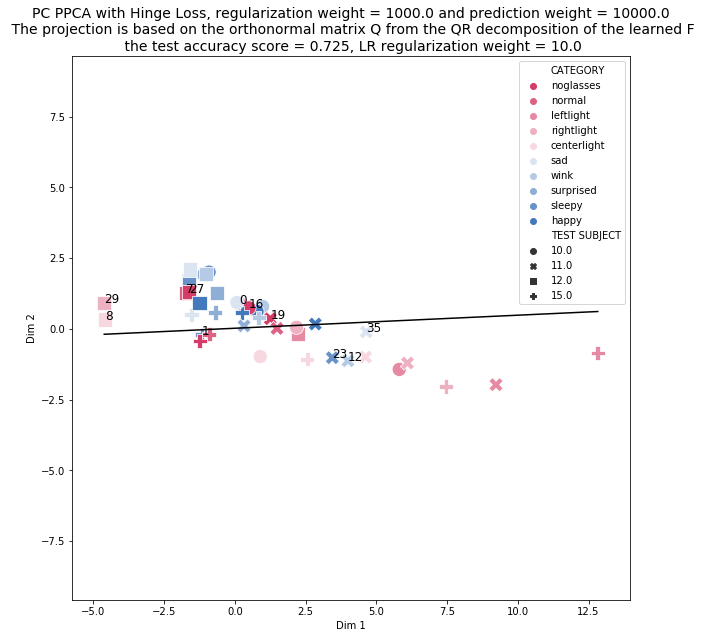

In [376]:

y_test_pred_q = clf_pc_q_best.predict(X_test_proj_best_q)
misclassified_idxs_q = np.argwhere(y_test_pred_q!=y_test)[:,0]
class0_idxs_q = np.argwhere(y_test_pred_q==0)[:,0]
class1_idxs_q = np.argwhere(y_test_pred_q==1)[:,0]

filename_q = "logit_projection_yale_acc{}_pred{}_reg{}_take2_q.png".format(np.max(scores_q), pred_weights[pred_weight_id], reg_weights[regular_weight_id])
df_test_q = pd.DataFrame({
    'dim1': X_test_proj_best_q[:,0],
    'dim2': X_test_proj_best_q[:,1],
    'pred_labels': y_test_pred_q,
    'true_labels': y_test,
    'filename': filenames_test,
    'category': categories_test,
    'subject': subjects_test    
    })
title_q = "PC PPCA with Hinge Loss, regularization weight = {} and prediction weight = {}\n The projection is based on the orthonormal matrix Q from the QR decomposition of the learned F\n the test accuracy score = {}, LR regularization weight = {}".format(reg_weights[regular_weight_id], pred_weights[pred_weight_id], np.max(scores_q),reg_weight_q)
plot_2D(df_test_q, filename_q, title_q, clf_pc_q_best, misclassified_idxs_q, True)

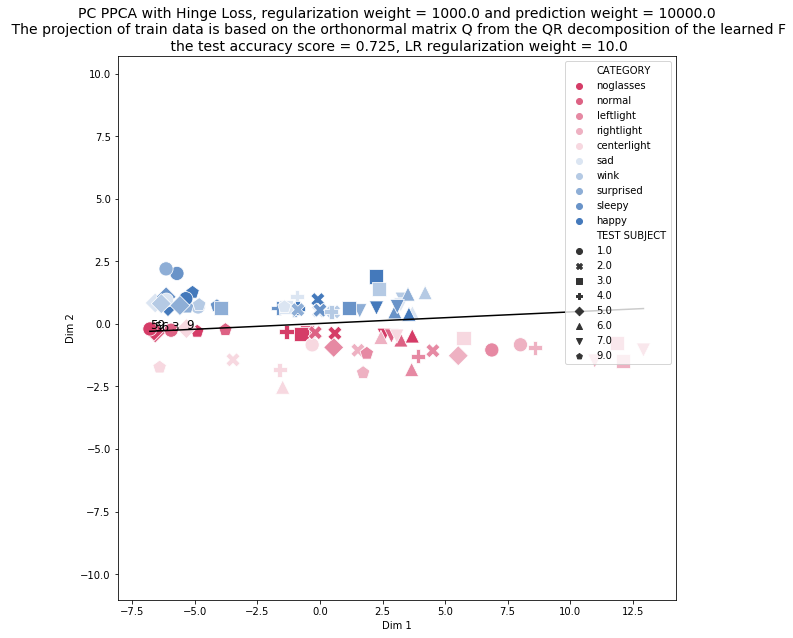

In [399]:
y_train_pred_q = clf_pc_q_best.predict(X_train_proj_best_q)
misclassified_idxs_q = np.argwhere(y_train_pred_q!=y_train)[:,0]
class0_idxs_q = np.argwhere(y_train_pred_q==0)[:,0]
class1_idxs_q = np.argwhere(y_train_pred_q==1)[:,0]

filename_q = "hinge_projection_train_yale_acc{}_pred{}_reg{}_take2_q.png".format(np.max(scores_q), pred_weights[pred_weight_id], reg_weights[regular_weight_id])
df_train_q = pd.DataFrame({
    'dim1': X_train_proj_best_q[:,0],
    'dim2': X_train_proj_best_q[:,1],
    'pred_labels': y_train_pred_q,
    'true_labels': y_train,
    'filename': filenames_train,
    'category': categories_train,
    'subject': subjects_train    
    })
title_q = "PC PPCA with Hinge Loss, regularization weight = {} and prediction weight = {}\n The projection of train data is based on the orthonormal matrix Q from the QR decomposition of the learned F\n the test accuracy score = {}, LR regularization weight = {}".format(reg_weights[regular_weight_id], pred_weights[pred_weight_id], np.max(scores_q),reg_weight_q)
plot_2D(df_train_q, filename_q, title_q, clf_pc_q_best, misclassified_idxs_q, True)


In [377]:
def plot_misclassified(df_test, filename, misclassified_idxs):
    columns = 6.0
    rows = np.round(misclassified_idxs.shape[0]/columns)
    fig=plt.figure(figsize=(columns*2, rows*3))
    
    for i in range(1, misclassified_idxs.shape[0] + 1):
        img = img_arr_test[misclassified_idxs[i-1]]
        fig.add_subplot(rows, columns, i)
        skimage.io.imshow(img)
        plt.title('idx: {} subject: {}\n category: {}'.format(misclassified_idxs[i-1], int(df_test.subject[misclassified_idxs[i-1]]), decode_category(int(df_test.category[misclassified_idxs[i-1]]))), fontsize = 12)
    plt.savefig(filename)
    plt.show()

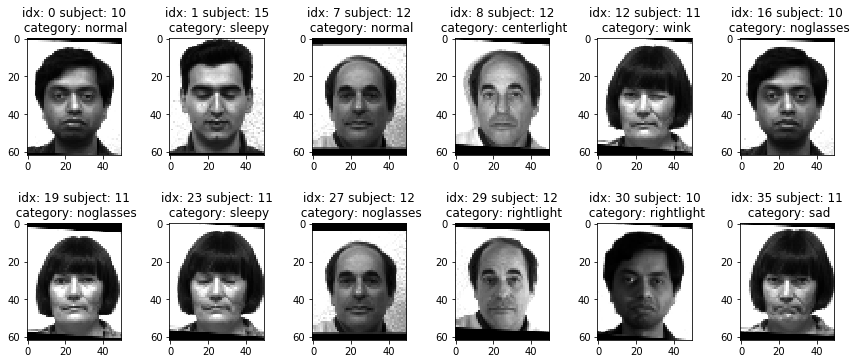

In [378]:
filename = "logit_misclass_f.png".format(test_acc_l_bfgs_b[regular_weight_id, pred_weight_id],pred_weights[pred_weight_id], reg_weights[regular_weight_id], latent_dim)
plot_misclassified(df_test_f, filename, misclassified_idxs_f)

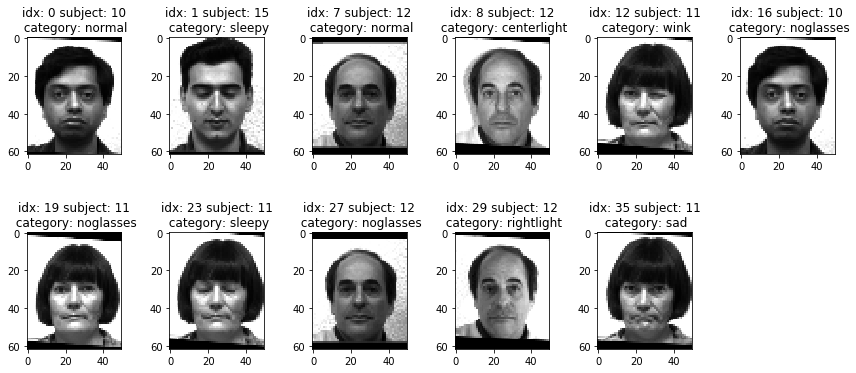

In [379]:
filename = "logit_misclass_q.png".format(test_acc_l_bfgs_b[regular_weight_id, pred_weight_id],pred_weights[pred_weight_id], reg_weights[regular_weight_id], latent_dim)
plot_misclassified(df_test_q, filename, misclassified_idxs_q)

In [259]:
misclassified_idxs_q

array([ 0,  6,  7,  8, 12, 19, 23, 25, 27, 29])

In [161]:
transformer = PCA(latent_dim)
x_train_transformed_pca = transformer.fit_transform(X_train)
x_test_transformed_pca = transformer.transform(X_test)
clf_pca = LogisticRegression().fit(x_train_transformed_pca, y_train)
test_acc_pca = clf_pca.score(x_test_transformed_pca, y_test)
test_probs_pca = clf_pca.predict_proba(x_test_transformed_pca)
y_test_pred_pca = clf_pca.predict(x_test_transformed_pca)
misclassified_idxs_pca = np.argwhere(y_test_pred_pca!=y_test)[:,0]
class0_idxs_pca = np.argwhere(y_test_pred_pca==0)[:,0]
class1_idxs_pca = np.argwhere(y_test_pred_pca==1)[:,0]


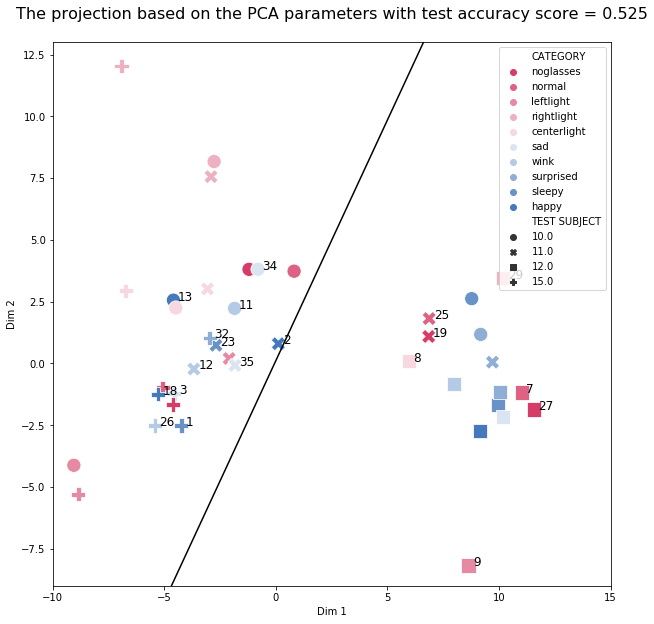

In [163]:
df_test_pca = pd.DataFrame({
'dim1': x_test_transformed_pca[:,0],
'dim2': x_test_transformed_pca[:,1],
'pred_labels': y_test_pred_pca,
'true_labels': y_test,
'filename': filenames_test,
'category': categories_test,
'subject': subjects_test    
})
plt.figure(figsize=(10,10))
for i in misclassified_idxs_pca:
     plt.text(df_test_pca.dim1[i]+0.2, df_test_pca.dim2[i], i, horizontalalignment='left', size='large', color='black')
plt.title("The projection based on the PCA parameters with test accuracy score = {}\n".format(test_acc_pca), fontsize=16)
w_clf = clf_pca.coef_[0]
a = -w_clf[0] / w_clf[1]
xx = np.linspace(-6, 7)
yy = a * xx - (clf_pca.intercept_[0]) /w_clf[1]
plt.xlim(-10, 15)
plt.ylim(-9, 13)
plt.plot(xx, yy, 'k-')

sns.scatterplot(x="dim1", y="dim2", hue="category", style="subject", data=df_test_pca,s =200, palette = sns.diverging_palette(1, 250, sep=1, n=10))
L=plt.legend()
L.get_texts()[0].set_text('CATEGORY')
L.get_texts()[1].set_text('noglasses')
L.get_texts()[2].set_text('normal')
L.get_texts()[3].set_text('leftlight')
L.get_texts()[4].set_text('rightlight')
L.get_texts()[5].set_text('centerlight')
L.get_texts()[6].set_text('sad')
L.get_texts()[7].set_text('wink')
L.get_texts()[8].set_text('surprised')
L.get_texts()[9].set_text('sleepy')
L.get_texts()[10].set_text('happy')
L.get_texts()[11].set_text('TEST SUBJECT')
plt.ylabel("Dim 2")
plt.xlabel("Dim 1")
plt.savefig("test_data_2d_pca.png")

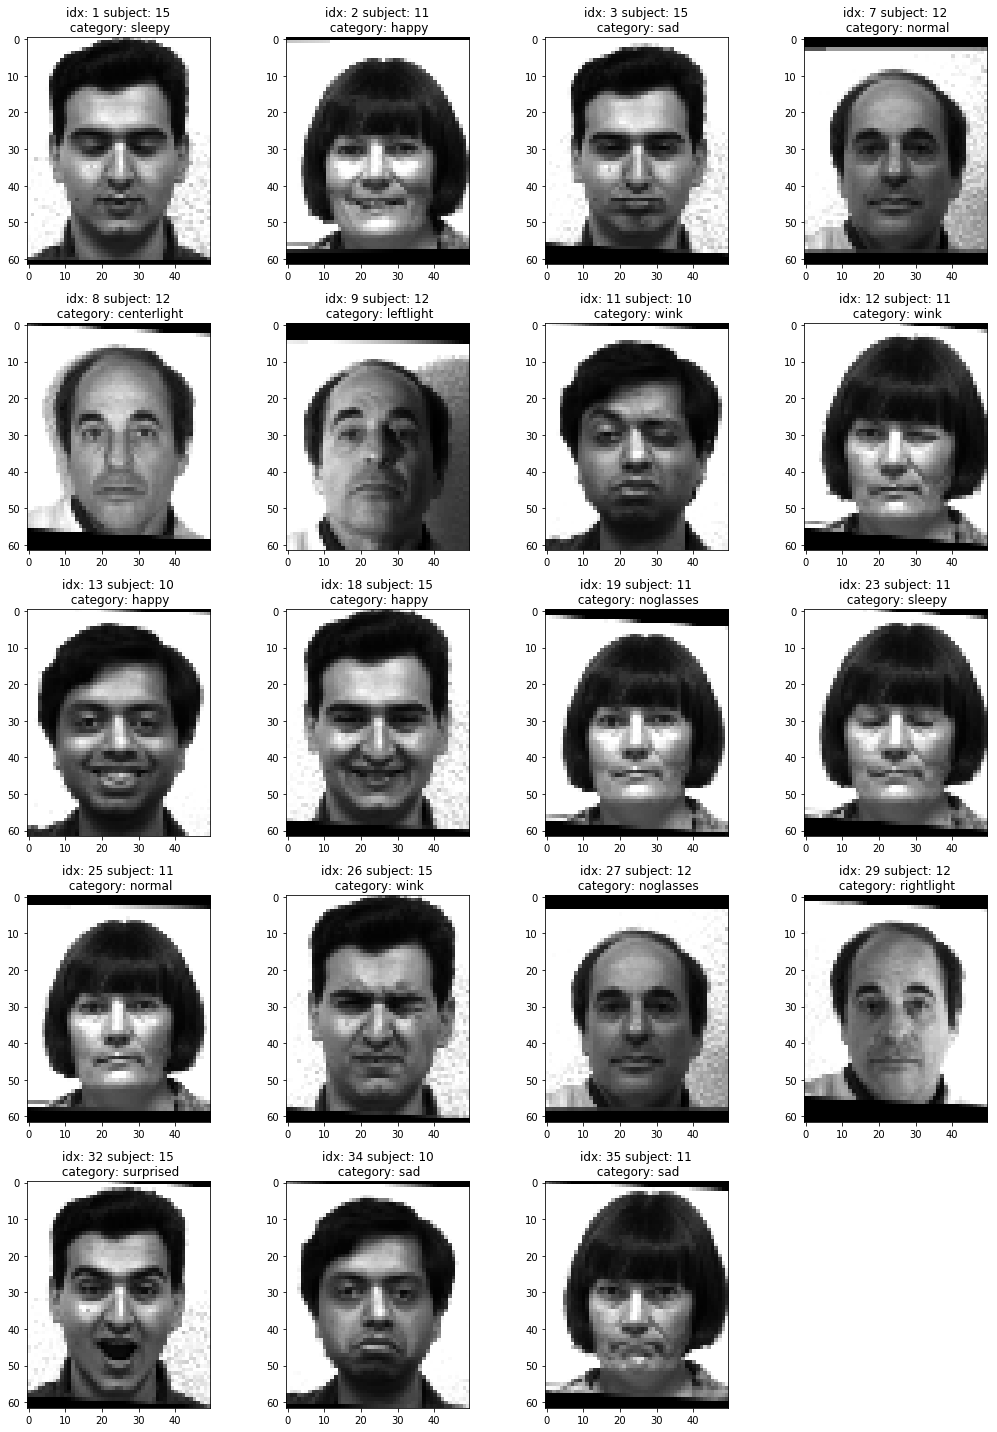

In [168]:
fig=plt.figure(figsize=(12,20))
columns = 4
rows = misclassified_idxs_pca.shape[0]/columns+1
for i in range(1, misclassified_idxs_pca.shape[0] +1):
    img = img_arr_test[np.argwhere(y_test_pred_pca!=y_test)[i-1,0]]
    fig.add_subplot(rows, columns, i)
    skimage.io.imshow(img)
    #plt.title('idx: {}\n filename: {}'.format(misclassified_idxs_pca[i-1], filenames_test[misclassified_idxs_pca[i-1]]))
    plt.title('idx: {} subject: {}\n category: {}'.format(misclassified_idxs_pca[i-1], int(df_test_pca.subject[misclassified_idxs_pca[i-1]]), decode_category(int(df_test_pca.category[misclassified_idxs_pca[i-1]]))), fontsize = 12)

plt.savefig("misclassified_images_pca.png")
plt.show()